In [1]:
# Importing the libraries
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
X = pd.read_csv('BibFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv')
y = pd.read_csv('BibDependentVariableLGAEncoded.csv')

In [4]:
y.size

12977

In [5]:
y.value_counts()

0
0    12039
1      938
dtype: int64

In [6]:
y.value_counts(normalize=True)*100

0
0    92.771827
1     7.228173
dtype: float64

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12977 entries, 0 to 12976
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ethnicity_Other             12977 non-null  float64
 1   ethnicity_South Asian       12977 non-null  float64
 2   ethnicity_White             12977 non-null  float64
 3   ethnicity_nan               12977 non-null  float64
 4   maternalDiabetes_No         12977 non-null  float64
 5   maternalDiabetes_Yes        12977 non-null  float64
 6   maternalDiabetes_missing    12977 non-null  float64
 7   fhEclampsia_No              12977 non-null  float64
 8   fhEclampsia_Not documented  12977 non-null  float64
 9   fhEclampsia_Yes             12977 non-null  float64
 10  fhEclampsia_missing         12977 non-null  float64
 11  gdm_No                      12977 non-null  float64
 12  gdm_Yes                     12977 non-null  float64
 13  gdm_missing                 129

In [8]:
# define a function that will evaluate the model performance 
def evaluate_model(y_test, y_pred):
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    disp  = skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    disp.set_title("Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0] 
    
    print('Classification Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
    print('Classification Error: %.3f' % (1 - metrics.accuracy_score(y_test, y_pred)))
    print('Sensitivity: %.3f' % metrics.recall_score(y_test, y_pred))
    print('Specificity: %.3f' % (TN / float(TN + FP)))
    print('False Positive Rate: %.3f' % (FP / float(TN + FP)))
    print('Precision: %.3f' % (TP / float(TP + FP)))
    print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))
    print('AUC: %.3f' % metrics.roc_auc_score(y_test, y_pred))

# Baseline Model

Logistic Regression Evaluation Metrics:
Model score: 0.933


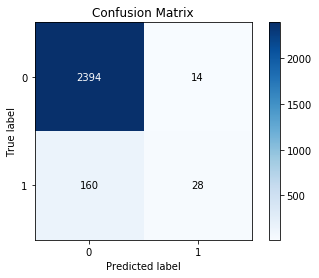

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2408
           1       0.67      0.15      0.24       188

    accuracy                           0.93      2596
   macro avg       0.80      0.57      0.60      2596
weighted avg       0.92      0.93      0.91      2596

Classification Accuracy: 0.933
Classification Error: 0.067
Sensitivity: 0.149
Specificity: 0.994
False Positive Rate: 0.006
Precision: 0.667
F1 Score: 0.243
AUC: 0.572


In [9]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')

# set max_iter=400 to overcome algortihm not converging

clf.fit(X_train, y_train)
print("Logistic Regression Evaluation Metrics:")

print("Model score: %.3f" % clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

# store the predicted probabilities for class 1 (Baby is LGA)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred)

# 1. Univariate Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data.

## ANOVA F-value

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fs = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fs.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

#print 10 best features
top10= featureScores.nlargest(10,'Score')
print(top10)

                 Feature       Score
40     premacrosomia_Yes  581.034641
44         bookingWeight  556.590278
46  thirdTrimesterWeight  431.973873
45            bookingBMI  401.598484
48        fastingGlucose  253.316485
56       maxFoetalWeight  218.868576
58       varFoetalWeight  208.582373
47        maternalHeight  168.547808
51          maxAbdomCirc  164.578745
59     rangeFoetalWeight  155.430641


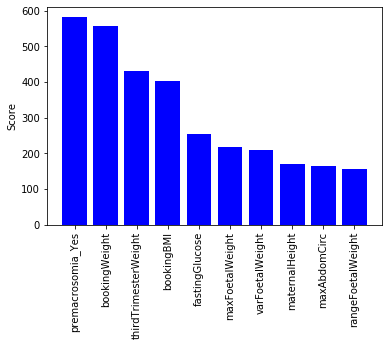

In [12]:
# Now plot top 10 features in histogram
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(rotation=90)
plt.ylabel("Score")
plt.bar(top10['Feature'], top10['Score'], color='b', align='center')
plt.show()

In [13]:
# make dataframe with features and their p values
p_values = pd.DataFrame({'column': X.columns, 'p_value':
                         bestfeatures.pvalues_}).sort_values('p_value')

pd.set_option('display.max_rows', 100)
# print (p_values) # print all features and their p_values


p_values[p_values['p_value'] < .05] # print features with p values less 0.05 only

,column,p_value
40,premacrosomia_Yes,1.264571e-125
44,bookingWeight,1.570193e-120
46,thirdTrimesterWeight,2.070286e-94
45,bookingBMI,5.271666e-88
48,fastingGlucose,1.681510e-56
56,maxFoetalWeight,4.010545e-49
58,varFoetalWeight,6.468683e-47
47,maternalHeight,2.659634e-38
51,maxAbdomCirc,1.909053e-37
59,rangeFoetalWeight,1.799789e-35


In [14]:
# Using training data only

# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=5)
fs = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fs.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Feature       Score
44         bookingWeight  449.344691
40     premacrosomia_Yes  394.753331
46  thirdTrimesterWeight  349.334451
45            bookingBMI  319.702814
48        fastingGlucose  191.710256
56       maxFoetalWeight  170.566281
58       varFoetalWeight  142.888881
47        maternalHeight  140.279271
59     rangeFoetalWeight  129.840686
51          maxAbdomCirc  127.742645


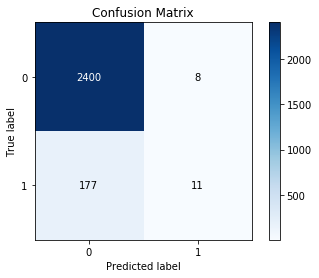

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2408
           1       0.58      0.06      0.11       188

    accuracy                           0.93      2596
   macro avg       0.76      0.53      0.53      2596
weighted avg       0.91      0.93      0.90      2596

Classification Accuracy: 0.929
Classification Error: 0.071
Sensitivity: 0.059
Specificity: 0.997
False Positive Rate: 0.003
Precision: 0.579
F1 Score: 0.106
AUC: 0.528


In [15]:
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# fit the model
log = LogisticRegression(solver='lbfgs')
log.fit(X_train_fs, y_train)

y_pred = log.predict(X_test_fs)

# evaluate predictions
evaluate_model(y_test, y_pred)

In [16]:
# Tune k in SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

kbest = SelectKBest(f_classif) 
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression(solver='lbfgs'))]) 
grid_search = GridSearchCV(pipeline, {'kbest__k': [5, 10, 15, 20, 25,30,35,40,45,50,55], 'lr__C': np.logspace(-10, 10, 5)}, scoring ='recall') 
grid_search.fit(X_train_fs, y_train) 

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('lr', LogisticRegression())]),
             param_grid={'kbest__k': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                      55],
                         'lr__C': array([1.e-10, 1.e-05, 1.e+00, 1.e+05, 1.e+10])},
             scoring='recall')

In [17]:
grid_search.best_params_

{'kbest__k': 5, 'lr__C': 1.0}

In [18]:
grid_search.best_score_

0.044

## Mutual Information

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Feature     Score
51          maxAbdomCirc  0.026623
44         bookingWeight  0.021684
56       maxFoetalWeight  0.019336
54        rangeAbdomCirc  0.015501
46  thirdTrimesterWeight  0.015211
59     rangeFoetalWeight  0.015182
45            bookingBMI  0.012896
58       varFoetalWeight  0.011602
40     premacrosomia_Yes  0.011361
47        maternalHeight  0.011229


# 2. Feature Importance
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

[0.00574513 0.0080716  0.01030095 0.00474666 0.00591675 0.0053961
 0.00538596 0.00398278 0.00250586 0.00202276 0.00145419 0.00333241
 0.00293331 0.00124392 0.00212186 0.00201912 0.0023627  0.0024151
 0.00141745 0.00121707 0.00034229 0.00033506 0.00789558 0.00833418
 0.00107941 0.00096559 0.00650527 0.00616309 0.0012481  0.00328549
 0.0028308  0.00125199 0.00947009 0.00168234 0.00975942 0.00131496
 0.00898749 0.00438869 0.00732921 0.01009784 0.03073892 0.00740326
 0.03935852 0.03217266 0.05180898 0.04871016 0.04848199 0.0463431
 0.04916643 0.04548502 0.04069176 0.04991519 0.03785358 0.0418144
 0.0417058  0.04192373 0.04738879 0.03809256 0.04627749 0.04680906]


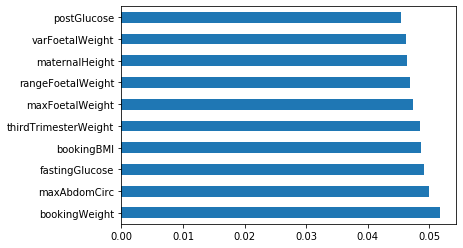

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# different reseults when I run:
# model = ExtraTreesClassifier(n_estimators=10)
# different results every time I run this

model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# 3. Recursive Feature Elimination


In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select =10)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 10
Selected Features: [False  True False False False  True False False False False False False
 False False False False False False  True False False  True False False
  True  True False False False False False False False False False False
 False  True False False  True False False False False False False False
 False False False False False  True False False False False  True False]
Feature Ranking: [40  1 24 12  6  1  7 43 31 29 13 28 34 49 26 27 21  9  1  8  4  1 32 33
  1  1 44 45 38 17 50 25 51 48 46 14 15  1 16  3  1  2 30 47 39  5 23 11
 10 22 18 19 35  1 42 37 20 36  1 41]


In [11]:
dfranking = pd.DataFrame(fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfranking],axis=1)
featureScores.columns = ['Feature','Ranking']  #naming the dataframe columns
# print(featureScores)
featureScores.loc[featureScores['Ranking'] == 1]

#print(featureScores.nlargest(10,'Score'))  #print 10 best features

,Feature,Ranking
1,ethnicity_South Asian,1
5,maternalDiabetes_Yes,1
18,gdmLifestyle_No,1
21,gdmMetformin_Yes,1
24,gdmNotDoc_No,1
25,gdmNotDoc_Not documented,1
37,pregdm_Yes,1
40,premacrosomia_Yes,1
53,varAbdomCirc,1
58,varFoetalWeight,1


Optimal number of features: 1


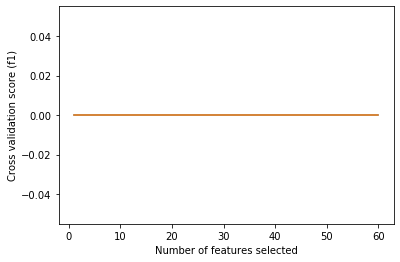

In [13]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="recall",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [23]:
rfecv.cv_results_

{'mean_test_score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_test_score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'split0_test_score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'split1_test_score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [52]:
X.columns

Index(['ethnicity_Other', 'ethnicity_South Asian', 'ethnicity_White',
       'ethnicity_nan', 'maternalDiabetes_No', 'maternalDiabetes_Yes',
       'maternalDiabetes_missing', 'fhEclampsia_No',
       'fhEclampsia_Not documented', 'fhEclampsia_Yes', 'fhEclampsia_missing',
       'gdm_No', 'gdm_Yes', 'gdm_missing', 'gdmDiet_No', 'gdmDiet_Yes',
       'gdmInsulin_No', 'gdmInsulin_Yes', 'gdmLifestyle_No',
       'gdmLifestyle_Yes', 'gdmMetformin_No', 'gdmMetformin_Yes',
       'gdmNoTreatment_No', 'gdmNoTreatment_Yes', 'gdmNotDoc_No',
       'gdmNotDoc_Not documented', 'gestHypertension_No',
       'gestHypertension_Yes', 'gestHypertension_missing', 'gestEclampsia_No',
       'gestEclampsia_Yes', 'gestEclampsia_missing', 'fhDiabetes_No',
       'fhDiabetes_Not documented', 'fhDiabetes_Yes', 'fhDiabetes_missing',
       'pregdm_No', 'pregdm_Yes', 'pregdm_missing', 'premacrosomia_No',
       'premacrosomia_Yes', 'premacrosomia_missing', 'maternalAge', 'parity',
       'bookingWeight', 'book